## Carregando as imagens para trabalhar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

In [ ]:
## Importando as imagens já processadas e normalizadas, conforme notebook "00_desafio3_preparar_df.ipynb"
df = np.load('/content/drive/MyDrive/Colab Notebooks/Introdução ao Deep Learning/desafio_3/df256.npz')

In [ ]:
imagens, rotulos = df['x'], df['y']

In [ ]:
rotulos.shape
print("rotulos shape: ", rotulos.shape)
print("rotulos size: ", rotulos.size)
print("rotulos type: ", type(rotulos))

rotulos shape:  (2193,)
rotulos size:  2193
rotulos type:  <class 'numpy.ndarray'>


In [ ]:
imagens.shape
print("imagens shape: ", imagens.shape)
print("imagens size: ", imagens.size)
print("imagens type: ", type(imagens))

imagens shape:  (2193, 256, 256)
imagens size:  143720448
imagens type:  <class 'numpy.ndarray'>


In [ ]:
imagens_data = imagens.reshape(imagens.shape[0], imagens.shape[1] * imagens.shape[2])

In [ ]:
n_amostra = imagens.shape[0]
n_pixels = imagens_data.shape[1]
n_classes = len(np.unique(rotulos))

print("Informações do dataset\n")
print(f"Nº de amostras: {n_amostra}")
print(f"tamanho das imagens: {imagens.shape[1]} x {imagens.shape[2]}")
print(f"Nº de pixels por imagem: {n_pixels}")
print(f"Nº de classes: {n_classes}" )
print("rotulos únicos:",np.unique(rotulos))

Informações do dataset

Nº de amostras: 2193
tamanho das imagens: 256 x 256
Nº de pixels por imagem: 65536
Nº de classes: 2
rotulos únicos: [0 1]


In [ ]:
def plot_imagens(imagens, ids_unicos, n_amostras_por_id = 1100):
    """
    Plota uma imagem de cada rotulo do dataset.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    LABELS = ['Sem achados', 'Cardiomegalia'] 
    fig, axarr = plt.subplots(nrows=1, ncols=len(np.unique(rotulos)), figsize=(15, 5))
    axarr = axarr.flatten()

    for ids_unicos in np.unique(rotulos):
        image_index = ids_unicos*n_amostras_por_id
        axarr[ids_unicos].imshow(imagens[image_index], cmap='gray')
        axarr[ids_unicos].set_xticks([])
        axarr[ids_unicos].set_yticks([])
        axarr[ids_unicos].set_title(f"{LABELS[ids_unicos]}")
    plt.suptitle(f"Nós temos {len(np.unique(rotulos))} diagnosticos distintos no dataset:")

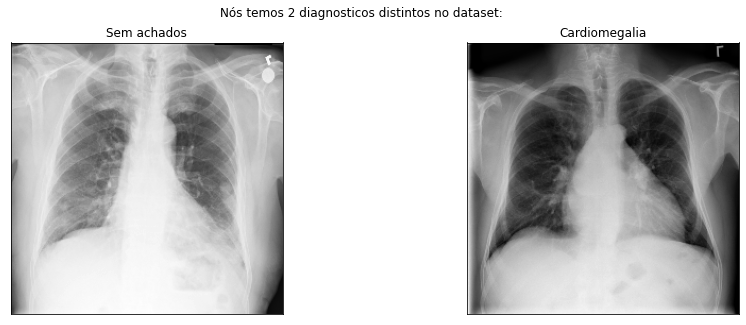

In [ ]:
plot_imagens(imagens, np.unique(rotulos))

In [ ]:
# Dividindo a base em treinamento e validação com uso da biblioteca SciKit Learn.
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df['x'], df['y'], test_size=0.20, random_state=42)

In [ ]:
df['x'].shape

(2193, 256, 256)

In [ ]:
X_train.shape, y_train.shape

((1754, 256, 256), (1754,))

In [ ]:
X_valid.shape, y_valid.shape

((439, 256, 256), (439,))

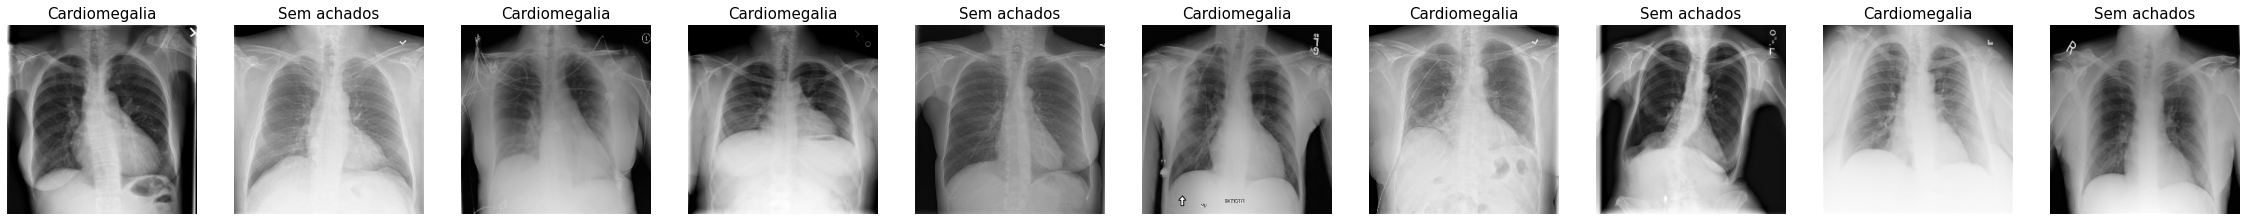

In [ ]:
# Plotando 10 imagens da base de treinamento
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))

num_images = 10
for i in range(num_images):
    row = X_train[i]
    label = y_train[i]
    LABELS = ['Sem achados', 'Cardiomegalia']

    image = row.reshape(256,256)
    plt.subplot(1, num_images, i+1)
    plt.title(LABELS[label], fontdict={'fontsize': 15})
    plt.axis('off')
    plt.imshow(image, cmap='gray')

## Abordagem ML para a classificação do exame


In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
num_classes = 2

In [ ]:
# Criando uma MLP de com 2 Dense de 512 neuronios e uma saida com ativação Softmax
# Camada Flatten de entrada adicionada apenas para transformar a imagem em um array sem editar a base que será usada também para a abordagem de DL

model_ml = keras.Sequential()
model_ml.add(Flatten(input_shape=(256,256))) ## Transformar a imagem em uma sequência de pixels
model_ml.add(Dense(512, activation="relu"))
model_ml.add(Dense(512, activation="relu"))
model_ml.add(Dense(num_classes, activation="softmax"))


In [ ]:
model_ml.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 512)               33554944  
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 33,818,626
Trainable params: 33,818,626
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Como teremos apenas duas categorias, o indicado é utilizar sparse_categorical_crossentropy como loss function 
model_ml.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [ ]:
# Treinaremos o modelo com mini_batch de 32 imagens, ao longo de 20 epocas
# Retornaremos o melhor conjunto de pesos que maximize a acurácia do modelo nos dados de validação

callback_parada = EarlyStopping(monitor='val_accuracy',
                                min_delta = 0.0001,
                                patience = 20,
                                verbose = True,
                                mode='max',
                                baseline = None,
                                restore_best_weights=True)

historico_ml = model_ml.fit(X_train,
                            y_train,
                            batch_size=32,
                            epochs=20,
                            validation_data=(X_valid, y_valid),
                            callbacks=[callback_parada])

Epoch 1/20
55/55 [==============================] - 6s 29ms/step - loss: 24.3707 - accuracy: 0.4966 - val_loss: 0.7763 - val_accuracy: 0.4761
Epoch 2/20
55/55 [==============================] - 1s 22ms/step - loss: 0.9118 - accuracy: 0.5023 - val_loss: 0.6928 - val_accuracy: 0.5239
Epoch 3/20
55/55 [==============================] - 1s 21ms/step - loss: 0.6940 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.4761
Epoch 4/20
55/55 [==============================] - 1s 20ms/step - loss: 0.6933 - accuracy: 0.4966 - val_loss: 0.6938 - val_accuracy: 0.4761
Epoch 5/20
55/55 [==============================] - 1s 20ms/step - loss: 0.6933 - accuracy: 0.5040 - val_loss: 0.6936 - val_accuracy: 0.4761
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.6933 - accuracy: 0.5040 - val_loss: 0.6935 - val_accuracy: 0.4761
Epoch 7/20
55/55 [==============================] - 1s 20ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.4761
Epoch 8/20
5

## Abordagem DL para a classificação do exame

In [ ]:
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
num_classes = 2

In [ ]:
# Criando uma CNN de com 3 blocos compostos por camada convolucional com filtros 3x3, Batch Normalization e Max Pooling
# Camada Flatten adicionada para transformar o tensor com a representação das caracteristicas em um array
# Camada Dense de ativação ReLU para ajustar os pesos referentes à relação entre as caracteristicas
# Dropout para melhorar generalização
# Saida Dense com ativação Softmax para classificação

model_dl = Sequential()
model_dl.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(256, 256, 1)))
model_dl.add(BatchNormalization())
model_dl.add(MaxPool2D((2, 2), strides=2, padding="same"))
model_dl.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model_dl.add(Dropout(0.2))
model_dl.add(BatchNormalization())
model_dl.add(MaxPool2D((2, 2), strides=2, padding="same"))
model_dl.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model_dl.add(BatchNormalization())
model_dl.add(MaxPool2D((2, 2), strides=2, padding="same"))
model_dl.add(Flatten())
model_dl.add(Dense(units=512, activation="relu"))
model_dl.add(Dropout(0.3))
model_dl.add(Dense(units=num_classes, activation="softmax"))

In [ ]:
model_dl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 75)      750       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 75)     300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 75)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 50)      33800     
                                                                 
 dropout (Dropout)           (None, 128, 128, 50)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 50)    

In [ ]:
# Como teremos apenas duas categorias, o indicado é utilizar sparse_categorical_crossentropy como loss function 

model_dl.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [ ]:
# Treinaremos o modelo com mini_batch de 32 imagens, ao longo de 20 epocas
# Retornaremos o melhor conjunto de pesos que maximize a acurácia do modelo nos dados de validação

callback_parada = EarlyStopping(monitor='val_accuracy',
                                min_delta = 0.0001,
                                patience = 20,
                                verbose = True,
                                mode='max',
                                baseline = None,
                                restore_best_weights=True)

historico_dl = model_dl.fit(X_train,
                            y_train,
                            batch_size=32,
                            epochs=20,
                            validation_data=(X_valid, y_valid),
                            callbacks=[callback_parada])

Epoch 1/20
55/55 [==============================] - 21s 187ms/step - loss: 5.1923 - accuracy: 0.5639 - val_loss: 1.7991 - val_accuracy: 0.5239
Epoch 2/20
55/55 [==============================] - 8s 154ms/step - loss: 0.8606 - accuracy: 0.5855 - val_loss: 1.3272 - val_accuracy: 0.5262
Epoch 3/20
55/55 [==============================] - 8s 142ms/step - loss: 0.9061 - accuracy: 0.6197 - val_loss: 1.5872 - val_accuracy: 0.5239
Epoch 4/20
55/55 [==============================] - 8s 141ms/step - loss: 0.7022 - accuracy: 0.6784 - val_loss: 2.7266 - val_accuracy: 0.5239
Epoch 5/20
55/55 [==============================] - 8s 141ms/step - loss: 0.6764 - accuracy: 0.6921 - val_loss: 1.2995 - val_accuracy: 0.5376
Epoch 6/20
55/55 [==============================] - 8s 141ms/step - loss: 0.6279 - accuracy: 0.7223 - val_loss: 1.1589 - val_accuracy: 0.5467
Epoch 7/20
55/55 [==============================] - 8s 142ms/step - loss: 0.4749 - accuracy: 0.7851 - val_loss: 0.7723 - val_accuracy: 0.6219
Epoch

## Avaliação das Diferenças

Na abordagem de ML percebemos que o modelo não consegue generalizar, apresentando uma acuracia similar à distribuição dos dados.

A abordagem de DL, utilizando CNN com Bottlneck, consegue gerar um espaço de representações que conseguiu melhores resultados do que a aplicação direta do MLP. Mesmo sendo um modelo bastante raso para a complexidade dos dados fornecidos, apresentou val_accuracy de 0,7494 na melhor época do treinamento, 22,5 pontos percentuais superior à abordagem de ML. 